In [204]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from matplotlib.transforms import Affine2D
from matplotlib.patches import ConnectionPatch

from PIL import Image

import skimage.io
import skimage.color
import skimage.exposure
from skimage.color import rgb2gray
from skimage.transform import rotate

import glob

# Data loader

In [205]:
def show_imgs(imgs, size=(10,6), title=""):
    fig, axes = plt.subplots(1,len(imgs), figsize=size)
    for i in range(len(imgs)):
        axes[i].imshow(imgs[i])

    fig.suptitle(title, fontsize=12)
    plt.show()

In [206]:
def data_loader(path: str, appear=False, show_size=(12,6), title = ""):
    image_paths = sorted(glob.glob(path))
    imgs = []

    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        imgs.append(img)
    
    if appear == True:
        show_imgs(imgs, show_size, title)

    return imgs

# Data cleaning

In [207]:
def nomalize_images(imgs, appear=False, title=""):

    nomal_imgs = []
    for img in imgs:
        img_norm = img / np.max(img)
        img_norm_uint8 = (img_norm * 255).astype(np.uint8)

        nomal_imgs.append(img_norm_uint8)

    if appear == True:
        show_imgs(nomal_imgs, title=title)

    return nomal_imgs

In [208]:
def to_gray_images(imgs, appear=False, title=""):
    
    gray_imgs = []
    for img in imgs:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_imgs.append(gray_img)

    if appear == True:
        show_imgs(gray_imgs, title=title)

    return gray_imgs

# Feature detector

In [209]:
def harris_coner_detector(imgs: list, blockSize: int, ksize: int, k_harris_parameter=0.04, threshold=0.01):

    keypoints = []
    for img in imgs:
        conner = cv2.cornerHarris(img, blockSize, ksize, k_harris_parameter)
        conner = cv2.dilate(conner, None)
        
        points = np.argwhere(conner > threshold * conner.max())
        keypoint = [cv2.KeyPoint(float(x[1]), float(x[0]), 1) for x in points]

        keypoints.append(keypoint)

    return keypoints

In [210]:
def plot_keypoints(imgs, keypoints):

    _, axes = plt.subplots(1,len(imgs), figsize=(10,6))
    for i in range(len(imgs)):
        points = np.array([list(keypoint.pt) for keypoint in keypoints[i]])

        axes[i].imshow(imgs[i])
        axes[i].scatter(points[:,0], points[:,1], marker='x', color='r')

    plt.show()

# Image matching

# Global alignment

# Blending and Compositing

In [211]:
def composite_images(image1, image2):
    """
    Composites two images into one.

    Parameters:
        image1 (np.array): The first image to composite.
        image2 (np.array): The second image to composite.

    Returns:
        np.array: The composited image.
    """
    # Convert the images to 3 channels if they are grayscale
    if len(image1.shape) == 2:
        image1 = cv2.cvtColor(image1, cv2.COLOR_GRAY2BGR)
    if len(image2.shape) == 2:
        image2 = cv2.cvtColor(image2, cv2.COLOR_GRAY2BGR)

    # Resize the images to the same shape
    height, width, channels = image1.shape
    image2 = cv2.resize(image2, (width, height))

    # Blend the images together
    alpha = 0.5
    composite_image = cv2.addWeighted(image1, alpha, image2, (1 - alpha), 0)

    return composite_image

# composed_image = composite_images(VIEW1, VIEW2)
# plt.imshow(composed_image)
# plt.show()

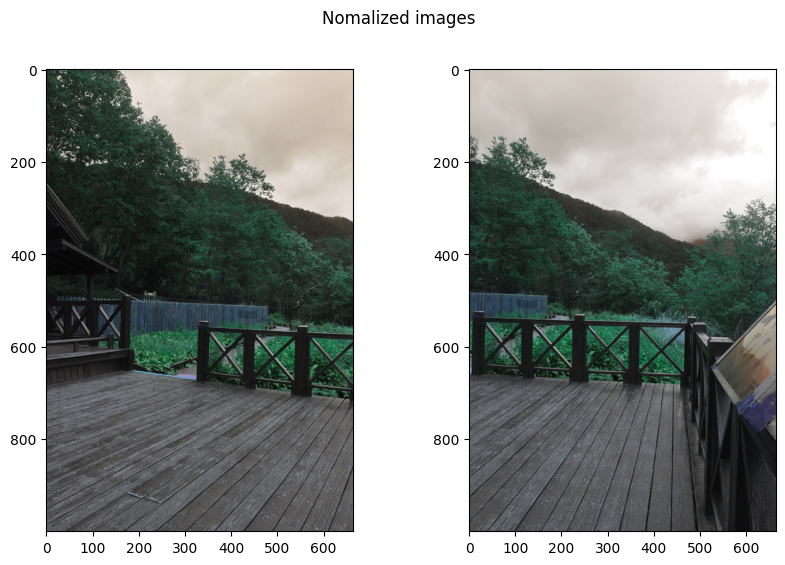

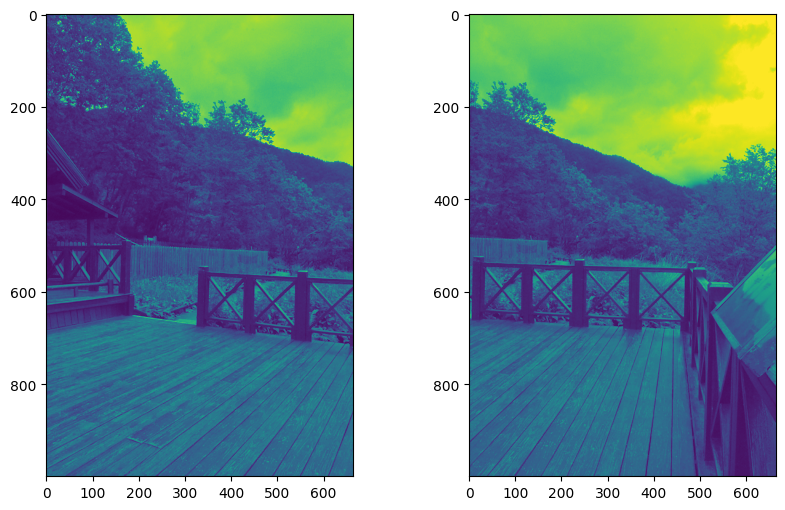

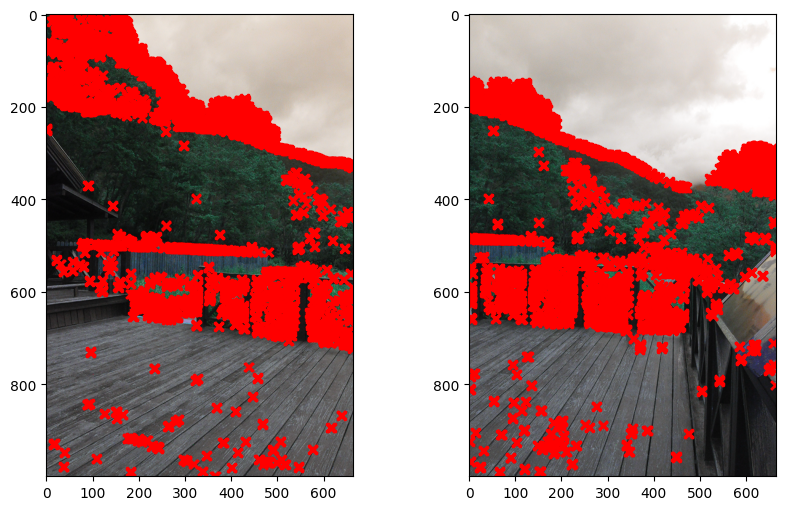

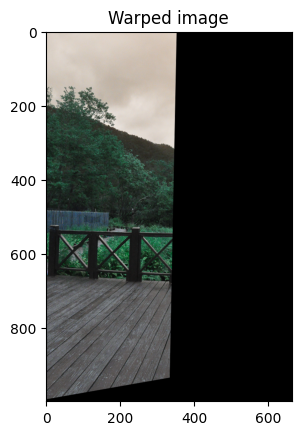

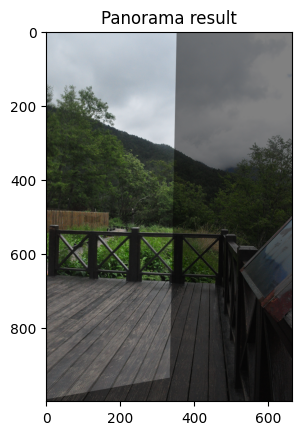

In [212]:
def stitching_images_harris_test():
    # Load images. CV2 reads in BGR format
    imgs = data_loader('data/xue-mountain/*.jpg')

    imgs = [img_src, img_des] = imgs[:2]

    # Normalize values, change data type
    imgs_norm_uint8 = nomalize_images(imgs, appear=True, title="Nomalized images")
    
    # Grayscale images
    gray_imgs = [gray_src, gray_des] = to_grayImage(imgs_norm_uint8, appear=True) 
    
    # Harris conner detector
    keypoints = [src_keypoints, des_keypoints] = harris_coner_detector(gray_imgs,
                                                        blockSize = 2, 
                                                        ksize = 3,
                                                        k_harris_parameter=0.04, 
                                                        threshold=0.01)
    
    
    plot_keypoints(imgs, keypoints)

    # Detect descriptors using SIFT
    sift = cv2.SIFT_create()
    src_keypoints, src_descriptors = sift.compute(gray_src, src_keypoints)
    des_keypoints, des_descriptors = sift.compute(gray_des, des_keypoints)

    # Match descriptors using FLANN matcher
    matcher = cv2.FlannBasedMatcher()
    matches = matcher.match(src_descriptors, des_descriptors)

    # Sort matches by distance
    matches = sorted(matches, key=lambda x:x.distance)

    # Select top matches
    num_top_matches = 50
    matches = matches[:num_top_matches]

    # Extract matched keypoints
    src_points = np.float32([src_keypoints[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    des_points = np.float32([des_keypoints[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Compute homography matrix using RANSAC
    H, mask = cv2.findHomography(src_points, des_points, cv2.RANSAC, 10.0)

    # Warp the source image to align with the destination image
    img_warped = cv2.warpPerspective(img_src, H, (img_des.shape[1], img_des.shape[0]))
    plt.imshow(img_warped)
    plt.title('Warped image')
    plt.show()

    # Combine the two images into a panorama
    panorama = np.zeros((max(img_des.shape[0], img_warped.shape[0]), img_des.shape[1] + img_warped.shape[1], 3), dtype=np.uint8)
    panorama[:img_des.shape[0], :img_des.shape[1], :] = img_des
    panorama[:img_warped.shape[0], img_des.shape[1]:, :] = img_warped

    # Blend the two images in the panorama
    alpha = 0.5
    panorama = cv2.addWeighted(panorama[:, :img_des.shape[1], :], alpha, panorama[:, img_des.shape[1]:, :], 1 - alpha, 0)

    # Fix the color channels of the blended image
    panorama = cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)

    return panorama

HARRIS_IMAGE_RESULT = stitching_images_harris_test()
plt.imshow(HARRIS_IMAGE_RESULT)
plt.title('Panorama result')
plt.show()

# Output

In [213]:
### General code structure

def stitching_images(img_src: np.array, img_des: np.array):
    gd_src = rgb2gray(img_src)
    gd_des = rgb2gray(img_des)

    ### TODO: Harris conner detecting and the patches - areas around conners

    ### TODO: SIFT computing the feature description by gradient of each patch

    ### TODO: Compute distance matrix based on SIFT of each patch

    ### TODO: Match each patch with from distance matrix above

    ### TODO: Run RANSAC to remove the outline pair of patch

    ### TODO: Composite two images into one

    ### TODO: Normalize the images (e.g. have same brightness levels)

    return [combined_image, Harris, num_inliers, residual]